# Example of Metric Learning in Embedded Space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
run_name = input()

 punish_same_pid


In [3]:
# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import Trainer
import frnn

sys.path.append('../..')

from LightningModules.Embedding.Models.weighted_layerless_embedding import WeightedLayerlessEmbedding
import copy
from LightningModules.Embedding.utils import multi_build_edges, graph_intersection

device = "cuda" if torch.cuda.is_available() else "cpu"

import wandb
from pytorch_lightning.callbacks import ModelCheckpoint

## Pytorch Lightning Model

In this example notebook, we will use an approach to ML called Pytorch Lightning. Pytorch is a library like Tensorflow, which is very popular in ML engineering. It's main appeal is foolproof tracking of gradients for backpropagation, and very easy manipulation of tensors on and off GPUs. 

Pytorch Lightning is an extension of Pytorch that makes some decisions about the best-practices for training. Instead of you writing the training loop yourself, and moving things on and off a GPU, it handles much of this for you. You write all the data loading logic, the loss functions, etc. into a `LightningModule` and then hand this module to a `Trainer`. Together, the module and trainer are the two objects that allow training and inference. 

So we start by importing a class that we have written ourselves, in this case a LightningModule that is in charge of loading TrackML (Codalab) data, and training and validating an embedding/metric learning model. 

### Construct PyLightning model

An ML model typically has many knobs to turn, as well as locations of data, some training preferences, and so on. For convenience, let's put all of these parameters into a YAML file and load it.

In [4]:
with open("Weighted_embedding_sweep.yaml") as f:
        sweep_hparams = yaml.load(f, Loader=yaml.FullLoader)
with open("Weighted_embedding_defaults.yaml") as f:
        default_hparams = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
sweep_configuration = {
    "name": run_name,
    "project": "ITk_barrel_full",
    "metric": {"name": "eff", "goal": "maximize"},
    "method": "grid",
    "parameters": sweep_hparams
}

In [6]:
def test_training():
    
    model = WeightedLayerlessEmbedding({**default_hparams})

    checkpoint_callback = ModelCheckpoint(
        monitor='cut_pur',
        mode="max",
        save_top_k=2,
        save_last=True)

    logger = WandbLogger()
    trainer = Trainer(gpus=1, max_steps=default_hparams["max_steps"], logger=logger, val_check_interval = 1000, num_sanity_val_steps=2, callbacks=[checkpoint_callback], default_root_dir="/global/cfs/cdirs/m3443/usr/ryanliu/ITk_embedding/")
    trainer.fit(model)

In [ ]:
# test_training()

## Metric Learning

### Train embedding

Finally! Let's train! We instantiate a `Trainer` class that knows things like which hardware to work with, how long to train for, and a **bunch** of default options that we ignore here. Check out the Trainer class docs in Pytorch Lightning. Suffice it to say that it clears away much repetitive boilerplate in training code.

In [6]:
def training():
    wandb.init()
    model = WeightedLayerlessEmbedding({**default_hparams, **wandb.config})

    checkpoint_callback = ModelCheckpoint(
        monitor='cut_pur',
        mode="max",
        save_top_k=2,
        save_last=True)

    logger = WandbLogger()
    trainer = Trainer(gpus=1, max_steps=default_hparams["max_steps"], val_check_interval = 1000, logger=logger, callbacks=[checkpoint_callback], default_root_dir="/global/cfs/cdirs/m3443/usr/ryanliu/ITk_embedding/")
    trainer.fit(model)

In [ ]:
sweep_id = wandb.sweep(sweep_configuration, project = "ITk_barrel_full")

# run the sweep
wandb.agent(sweep_id, function=training)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: iml18m39
Sweep URL: https://wandb.ai/exatrkx/ITk_barrel_full/sweeps/iml18m39


wandb: Agent Starting Run: qgh55wba with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 0.4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: exatrkx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:06<00:06,  6.97s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:28<00:01,  6.71it/s, loss=0.343, v_num=5wba]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1001/1010 [02:01<00:01,  8.23it/s, loss=0.298, v_num=5wba]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1001/1010 [01:51<00:01,  8.96it/s, loss=0.27, v_num=5wba] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1001/1010 [01:46<00:00,  9.44it/s, loss=0.254, v_num=5wba]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1001/1010 [01:48<00:00,  9.23it/s, loss=0.248, v_num=5wba]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1001/1010 [01:48<00:00,  9.20it/s, loss=0.243, v_num=5wba]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1001/1010 [01:43<00:00,  9.64it/s, loss=0.239, v_num=5wba]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1001/1010 [01:47<00:00,  9.28it/s, loss=0.237, v_num=5wba]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1001/1010 [01:43<00:00,  9.67it/s, loss=0.236,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁▄▆▇██████
cut_pur,▁▃▄▅▆▇████
eff,▇▃▁▆▆▇█▇▇▆
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▂▁▁▂▄▅████
r@eff0.98,█▄▃▂▂▂▁▁▁▁
train_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▃▂▂▁▁▁▁▁
weighted_eff,▁▄▆▇██████


wandb: Agent Starting Run: 67rkh6dp with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 0.6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.91s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:35<00:01,  6.45it/s, loss=0.32, v_num=h6dp]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:09<00:01,  7.70it/s, loss=0.285, v_num=h6dp]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:00<00:01,  8.33it/s, loss=0.265, v_num=h6dp]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [01:54<00:01,  8.77it/s, loss=0.255, v_num=h6dp]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [01:54<00:01,  8.76it/s, loss=0.252, v_num=h6dp]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1001/1010 [01:53<00:01,  8.85it/s, loss=0.248, v_num=h6dp]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1001/1010 [01:54<00:01,  8.78it/s, loss=0.246, v_num=h6dp]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1001/1010 [01:53<00:01,  8.85it/s, loss=0.245, v_num=h6dp]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1001/1010 [01:53<00:01,  8.81it/s, loss=0.244, 

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁▆▇███████
cut_pur,▁▂▄▅▆█▇▇▇█
eff,▇█▆▄▃▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▂▃▅▆█▇▇▇█
r@eff0.98,█▅▃▂▁▁▁▁▁▁
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▂▁▁▁▁▁▁
weighted_eff,▁▆████████


wandb: Agent Starting Run: y6oo1s6r with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 0.8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.95s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:40<00:01,  6.25it/s, loss=0.304, v_num=1s6r]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1001/1010 [02:27<00:01,  6.80it/s, loss=0.266, v_num=1s6r]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1001/1010 [02:07<00:01,  7.86it/s, loss=0.252, v_num=1s6r]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1001/1010 [02:00<00:01,  8.30it/s, loss=0.245, v_num=1s6r]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [01:59<00:01,  8.37it/s, loss=0.242, v_num=1s6r]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [01:58<00:01,  8.46it/s, loss=0.239, v_num=1s6r]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1001/1010 [01:56<00:01,  8.58it/s, loss=0.238, v_num=1s6r]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [01:55<00:01,  8.69it/s, loss=0.237, v_num=1s6r]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1001/1010 [01:55<00:01,  8.68it/s, loss=0.236,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁▆████████
cut_pur,▁▂▃▅▆▆▇▇██
eff,█▆▄▂▂▂▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▁▃▅▅▅▇▇▇█
r@eff0.98,█▇▇▃▃▄▁▁▁▁
train_loss,█▆▅▄▄▃▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▁▁▁▁▁▁
weighted_eff,▁▇████▇▇█▇


wandb: Agent Starting Run: 4yo8ro2b with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.71s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:44<00:01,  6.09it/s, loss=0.288, v_num=ro2b]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:33<00:01,  6.51it/s, loss=0.251, v_num=ro2b]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:13<00:01,  7.49it/s, loss=0.24, v_num=ro2b] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:02<00:01,  8.18it/s, loss=0.234, v_num=ro2b]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [01:54<00:01,  8.70it/s, loss=0.231, v_num=ro2b]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:00<00:01,  8.32it/s, loss=0.229, v_num=ro2b]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [01:59<00:01,  8.34it/s, loss=0.228, v_num=ro2b]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [01:58<00:01,  8.41it/s, loss=0.227, v_num=ro2b]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [01:56<00:01,  8.58it/s, loss=0.227,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▃▄▅▆▇████
eff,█▆▃▂▂▂▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▄▄▅▆▇████
r@eff0.98,▁▃█▇▆▅▄▄▄▃
train_loss,█▆▅▄▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▁▁▁▁▁▂
weighted_eff,▁█▆▄▄▄▅▅▅▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wxo91i31 with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 1.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.71s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:41<00:01,  6.21it/s, loss=0.271, v_num=1i31]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:33<00:01,  6.51it/s, loss=0.233, v_num=1i31]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1001/1010 [02:24<00:01,  6.94it/s, loss=0.225, v_num=1i31]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:10<00:01,  7.68it/s, loss=0.22, v_num=1i31] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1001/1010 [02:06<00:01,  7.88it/s, loss=0.219, v_num=1i31]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:37<00:01,  6.37it/s, loss=0.218, v_num=1i31]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:27<00:01,  6.78it/s, loss=0.216, v_num=1i31]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:47<00:01,  5.98it/s, loss=0.216, v_num=1i31]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:01<00:01,  8.20it/s, loss=0.216,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▂▄▆▆▇████
eff,█▆▃▂▂▂▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▂▃▆▇▇████
r@eff0.98,▁▆█▆▆▆▅▅▅▅
train_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▂▂▂▂▂
weighted_eff,▁█▄▂▃▂▂▂▂▃


wandb: Agent Starting Run: vfasa8qz with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 1.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.63s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:42<00:01,  6.16it/s, loss=0.256, v_num=a8qz]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:36<00:01,  6.40it/s, loss=0.221, v_num=a8qz]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:29<00:01,  6.69it/s, loss=0.211, v_num=a8qz]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:16<00:01,  7.35it/s, loss=0.207, v_num=a8qz]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:14<00:01,  7.43it/s, loss=0.206, v_num=a8qz]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:14<00:01,  7.43it/s, loss=0.204, v_num=a8qz]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:11<00:01,  7.61it/s, loss=0.204, v_num=a8qz]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:11<00:01,  7.58it/s, loss=0.203, v_num=a8qz]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:08<00:01,  7.79it/s, loss=0.203,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▄▄▅▆▇████
eff,█▅▃▂▂▂▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▄▄▅▆▇████
r@eff0.98,▁▅█▇▇▆▆▆▆▆
train_loss,█▆▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▁▂▂▂▂▂
weighted_eff,██▅▂▁▂▁▁▁▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r9w7ksyb with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.72s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:44<00:01,  6.09it/s, loss=0.225, v_num=ksyb]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:35<00:01,  6.44it/s, loss=0.2, v_num=ksyb]  
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:35<00:01,  6.43it/s, loss=0.187, v_num=ksyb]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:26<00:01,  6.83it/s, loss=0.183, v_num=ksyb]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:26<00:01,  6.84it/s, loss=0.182, v_num=ksyb]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.92it/s, loss=0.182, v_num=ksyb]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:19<00:01,  7.19it/s, loss=0.181, v_num=ksyb]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.90it/s, loss=0.181, v_num=ksyb]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:22<00:01,  7.01it/s, loss=0.18, 

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▃▅▆▇▇████
eff,█▅▃▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▃▅▆▇▇████
r@eff0.98,▁▇███▇▇▇▇▇
train_loss,█▆▅▅▄▃▃▃▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▂▂▂▂▂
weighted_eff,█▆▃▂▂▁▁▁▁▁


wandb: Agent Starting Run: wknpjlvs with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.77s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:39<00:01,  6.28it/s, loss=0.192, v_num=jlvs]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:45<00:01,  6.04it/s, loss=0.167, v_num=jlvs]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:38<00:01,  6.30it/s, loss=0.157, v_num=jlvs]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:38<00:01,  6.29it/s, loss=0.152, v_num=jlvs]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:40<00:01,  6.22it/s, loss=0.151, v_num=jlvs]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:40<00:01,  6.22it/s, loss=0.15, v_num=jlvs] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:39<00:01,  6.28it/s, loss=0.149, v_num=jlvs]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:40<00:01,  6.25it/s, loss=0.149, v_num=jlvs]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:45<00:01,  6.05it/s, loss=0.149,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▄▆▆▇▇████
eff,█▄▂▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▄▆▆▇▇████
r@eff0.98,▁▆▇██████▇
train_loss,█▆▆▅▅▄▃▃▃▂▂▂▂▂▁▂▂▁▁▂▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▂▁▁▂▁▁▁▂
weighted_eff,█▆▁▂▂▁▁▁▁▁


wandb: Agent Starting Run: rdntub1z with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.79s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:43<00:01,  6.12it/s, loss=0.159, v_num=ub1z]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:41<00:01,  6.20it/s, loss=0.145, v_num=ub1z]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:44<00:01,  6.09it/s, loss=0.14, v_num=ub1z] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:41<00:01,  6.18it/s, loss=0.133, v_num=ub1z]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:43<00:01,  6.12it/s, loss=0.132, v_num=ub1z]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:42<00:01,  6.14it/s, loss=0.131, v_num=ub1z]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:46<00:01,  5.99it/s, loss=0.13, v_num=ub1z] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:43<00:01,  6.12it/s, loss=0.13, v_num=ub1z]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:49<00:01,  5.91it/s, loss=0.13, v

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▃▅▇▇▇████
eff,█▅▃▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▄▅▇▇▇████
r@eff0.98,▁▇▇███████
train_loss,█▆▆▅▆▄▄▃▃▃▃▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▂▁▁▁▁▁▁▁
weighted_eff,██▄▂▁▁▂▁▁▁


wandb: Agent Starting Run: 3uom7pg9 with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.85s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:39<00:01,  6.25it/s, loss=0.136, v_num=7pg9]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:44<00:01,  6.09it/s, loss=0.127, v_num=7pg9]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:45<00:01,  6.03it/s, loss=0.121, v_num=7pg9]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:48<00:01,  5.95it/s, loss=0.118, v_num=7pg9]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:41<00:01,  6.20it/s, loss=0.117, v_num=7pg9]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:48<00:01,  5.92it/s, loss=0.116, v_num=7pg9]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:47<00:01,  5.98it/s, loss=0.115, v_num=7pg9]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:48<00:01,  5.94it/s, loss=0.115, v_num=7pg9]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:43<00:01,  6.12it/s, loss=0.115,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁▇████████
cut_pur,▁▄▇█▇█████
eff,█▄▂▁▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▄▇█▇█████
r@eff0.98,▁▅▇▇█▇████
train_loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▃▂▁▁▁▁▁▁
weighted_eff,█▅▂▁▂▁▂▂▂▂


wandb: Agent Starting Run: q8vpqzkm with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.71s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:38<00:01,  6.32it/s, loss=0.122, v_num=qzkm]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:41<00:01,  6.18it/s, loss=0.113, v_num=qzkm]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:51<00:01,  5.81it/s, loss=0.11, v_num=qzkm] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:52<00:01,  5.81it/s, loss=0.106, v_num=qzkm]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:52<00:01,  5.80it/s, loss=0.105, v_num=qzkm]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:51<00:01,  5.82it/s, loss=0.105, v_num=qzkm]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:49<00:01,  5.89it/s, loss=0.104, v_num=qzkm]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:53<00:01,  5.75it/s, loss=0.104, v_num=qzkm]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:46<00:01,  6.01it/s, loss=0.104,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▄▆▇██████
eff,█▅▃▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▄▆▇██████
r@eff0.98,▁▄▇▇▇▇████
train_loss,█▇▆▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▃▂▂▁▁▁▁▁
weighted_eff,▁█▆▄▃▃▄▄▄▃


wandb: Agent Starting Run: sigat2u2 with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.98s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:42<00:01,  6.15it/s, loss=0.0945, v_num=t2u2]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:42<00:01,  6.15it/s, loss=0.0916, v_num=t2u2]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:45<00:01,  6.06it/s, loss=0.0891, v_num=t2u2]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:50<00:01,  5.86it/s, loss=0.0873, v_num=t2u2]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:51<00:01,  5.85it/s, loss=0.0868, v_num=t2u2]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:48<00:01,  5.92it/s, loss=0.0862, v_num=t2u2]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:48<00:01,  5.94it/s, loss=0.0857, v_num=t2u2]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:55<00:01,  5.71it/s, loss=0.0856, v_num=t2u2]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:52<00:01,  5.80it/s, los

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▃▆▇▇█████
eff,█▆▃▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▃▆▇▇█████
r@eff0.98,▁▄▅▇▇▇████
train_loss,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▃▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁
weighted_eff,█▆▄▂▁▁▁▁▁▁


wandb: Agent Starting Run: 6vy1swbz with config:
wandb: 	punish_same_pid: True
wandb: 	weight_ratio: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.84s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:43<00:01,  6.11it/s, loss=0.0788, v_num=swbz]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:44<00:01,  6.08it/s, loss=0.0771, v_num=swbz]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:48<00:01,  5.94it/s, loss=0.0755, v_num=swbz]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:51<00:01,  5.82it/s, loss=0.0742, v_num=swbz]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:55<00:01,  5.68it/s, loss=0.0739, v_num=swbz]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:54<00:01,  5.73it/s, loss=0.0735, v_num=swbz]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:49<00:01,  5.89it/s, loss=0.0732, v_num=swbz]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:53<00:01,  5.78it/s, loss=0.0732, v_num=swbz]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:50<00:01,  5.86it/s, los

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▃▅▇▇█████
eff,█▆▃▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▃▆▇▇█████
r@eff0.98,▁▃▅▆▇▇████
train_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁
weighted_eff,█▆▄▂▁▁▁▁▁▁


wandb: Agent Starting Run: lrl9k544 with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 0.4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.66s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:09<00:01,  7.75it/s, loss=0.352, v_num=k544]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1001/1010 [01:53<00:01,  8.85it/s, loss=0.309, v_num=k544]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1001/1010 [01:41<00:00,  9.83it/s, loss=0.282, v_num=k544]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [01:37<00:00, 10.22it/s, loss=0.265, v_num=k544]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [01:35<00:00, 10.43it/s, loss=0.26, v_num=k544] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1001/1010 [01:36<00:00, 10.40it/s, loss=0.255, v_num=k544]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [01:34<00:00, 10.63it/s, loss=0.251, v_num=k544]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [01:35<00:00, 10.46it/s, loss=0.25, v_num=k544] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [01:36<00:00, 10.33it/s, loss=0.249,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁▅▇███████
cut_pur,▁▂▃▄▅▆▇███
eff,▃█▆▆▄▃▃▂▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▂▂▃▄▅▇▇█▇
r@eff0.98,█▅▃▂▂▁▁▁▁▁
train_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▂▂▁▁▁▁▁
weighted_eff,▁▅▇███████


wandb: Agent Starting Run: 8nxh8m6c with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 0.6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.70s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1001/1010 [02:21<00:01,  7.10it/s, loss=0.331, v_num=8m6c]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:02<00:01,  8.14it/s, loss=0.292, v_num=8m6c]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [01:48<00:01,  9.23it/s, loss=0.275, v_num=8m6c]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [01:38<00:00, 10.18it/s, loss=0.264, v_num=8m6c]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [01:39<00:00, 10.02it/s, loss=0.26, v_num=8m6c] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [01:42<00:01,  9.72it/s, loss=0.257, v_num=8m6c]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [01:35<00:00, 10.51it/s, loss=0.254, v_num=8m6c]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [01:38<00:00, 10.14it/s, loss=0.253, v_num=8m6c]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [01:34<00:00, 10.56it/s, loss=0.253,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁▇████████
cut_pur,▁▂▄▆▆▇▇███
eff,█▇▄▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▂▄▆▆▇▇███
r@eff0.98,█▄▃▂▂▂▁▁▁▁
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁
weighted_eff,▁██▇▇▇▇▇▇▇


wandb: Agent Starting Run: 4yyu72fm with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 0.8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.41s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:25<00:01,  6.89it/s, loss=0.315, v_num=72fm]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1001/1010 [02:09<00:01,  7.73it/s, loss=0.274, v_num=72fm]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [01:49<00:01,  9.13it/s, loss=0.261, v_num=72fm]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [01:46<00:01,  9.43it/s, loss=0.254, v_num=72fm]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [01:44<00:01,  9.57it/s, loss=0.251, v_num=72fm]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [01:40<00:01,  9.91it/s, loss=0.249, v_num=72fm]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [01:40<00:01,  9.93it/s, loss=0.246, v_num=72fm]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [01:39<00:00, 10.02it/s, loss=0.245, v_num=72fm]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [01:37<00:00, 10.25it/s, loss=0.245,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▃▅▆▇▇████
eff,█▇▄▂▂▂▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▃▅▇▇▇████
r@eff0.98,█▂▃▂▂▂▁▁▁▂
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁
weighted_eff,▁█▇▆▆▆▆▆▆▆


wandb: Agent Starting Run: fhmboc26 with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.38s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.90it/s, loss=0.3, v_num=oc26] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1001/1010 [02:12<00:01,  7.56it/s, loss=0.258, v_num=oc26]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [01:50<00:01,  9.05it/s, loss=0.247, v_num=oc26]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1001/1010 [01:47<00:00,  9.34it/s, loss=0.242, v_num=oc26]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [01:45<00:01,  9.50it/s, loss=0.24, v_num=oc26] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [01:43<00:01,  9.63it/s, loss=0.238, v_num=oc26]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [01:43<00:01,  9.67it/s, loss=0.236, v_num=oc26]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [01:42<00:01,  9.75it/s, loss=0.235, v_num=oc26]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [01:42<00:01,  9.71it/s, loss=0.235, 

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▂▆▇▇█████
eff,█▆▃▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▂▆▇▇█████
r@eff0.98,▁█▅▅▅▅▄▄▄▄
train_loss,█▆▅▅▄▃▃▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁
weighted_eff,▁█▅▅▅▅▅▅▅▅


wandb: Agent Starting Run: 5ixwahvl with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 1.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.43s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1001/1010 [02:22<00:01,  7.02it/s, loss=0.285, v_num=ahvl]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:18<00:01,  7.24it/s, loss=0.243, v_num=ahvl]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:10<00:01,  7.66it/s, loss=0.235, v_num=ahvl]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [01:56<00:01,  8.60it/s, loss=0.226, v_num=ahvl]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:00<00:01,  8.30it/s, loss=0.225, v_num=ahvl]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [01:51<00:01,  8.98it/s, loss=0.224, v_num=ahvl]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [01:51<00:01,  9.01it/s, loss=0.222, v_num=ahvl]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [01:51<00:01,  8.99it/s, loss=0.222, v_num=ahvl]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [01:50<00:01,  9.09it/s, loss=0.221,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▃▅▇▇█████
eff,█▅▃▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▃▅▇▇█████
r@eff0.98,▁▇██▇▇▇▇▇▇
train_loss,█▆▅▅▅▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▂▁▁▁▁▁▁▁
weighted_eff,▅█▃▂▁▁▁▂▁▁


wandb: Agent Starting Run: b4gqegux with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 1.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.58s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:21<00:01,  7.06it/s, loss=0.266, v_num=egux]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.90it/s, loss=0.229, v_num=egux]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1001/1010 [02:14<00:01,  7.45it/s, loss=0.217, v_num=egux]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:04<00:01,  8.05it/s, loss=0.211, v_num=egux]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:01<00:01,  8.26it/s, loss=0.21, v_num=egux] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1001/1010 [01:56<00:01,  8.58it/s, loss=0.209, v_num=egux]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1001/1010 [01:52<00:01,  8.87it/s, loss=0.208, v_num=egux]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [01:58<00:01,  8.42it/s, loss=0.208, v_num=egux]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [01:55<00:01,  8.63it/s, loss=0.207,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▄▅▇▇▇████
eff,█▄▃▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▅▅▇██████
r@eff0.98,▁▅█▇▇▇▇▇▇▇
train_loss,█▆▆▅▅▃▃▂▃▂▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▁▁▁▁▁▁
weighted_eff,█▇▃▂▁▁▂▂▂▂


wandb: Agent Starting Run: d8tlsuyd with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.29s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.92it/s, loss=0.244, v_num=suyd]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:20<00:01,  7.12it/s, loss=0.208, v_num=suyd]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1001/1010 [02:14<00:01,  7.43it/s, loss=0.193, v_num=suyd]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:13<00:01,  7.50it/s, loss=0.187, v_num=suyd]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1001/1010 [02:09<00:01,  7.72it/s, loss=0.186, v_num=suyd]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:10<00:01,  7.65it/s, loss=0.185, v_num=suyd]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:03<00:01,  8.09it/s, loss=0.184, v_num=suyd]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:09<00:01,  7.75it/s, loss=0.184, v_num=suyd]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:07<00:01,  7.86it/s, loss=0.183,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▄▄▇▇▇████
eff,█▅▃▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▄▄▇▇▇████
r@eff0.98,▁▆████████
train_loss,█▇▆▅▅▄▃▃▄▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▁▁▁▁▁▁
weighted_eff,██▃▂▂▁▁▁▂▁


wandb: Agent Starting Run: 040pkrtw with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.54s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:27<00:01,  6.78it/s, loss=0.194, v_num=krtw]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:21<00:01,  7.07it/s, loss=0.179, v_num=krtw]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:23<00:01,  6.96it/s, loss=0.166, v_num=krtw]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:26<00:01,  6.83it/s, loss=0.158, v_num=krtw]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:20<00:01,  7.11it/s, loss=0.156, v_num=krtw]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:22<00:01,  6.99it/s, loss=0.155, v_num=krtw]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:21<00:01,  7.09it/s, loss=0.154, v_num=krtw]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:16<00:01,  7.32it/s, loss=0.154, v_num=krtw]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:17<00:01,  7.25it/s, loss=0.153,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▄▅▇▇▇████
eff,█▅▃▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▄▅▇▇█████
r@eff0.98,▁▅▇███████
train_loss,█▆▆▅▅▄▄▃▄▃▃▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▁▁▁▁▁▁▁
weighted_eff,▇█▄▁▁▁▁▁▁▁


wandb: Agent Starting Run: mbr12jkl with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.27s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.90it/s, loss=0.163, v_num=2jkl]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:27<00:01,  6.80it/s, loss=0.151, v_num=2jkl]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:25<00:01,  6.86it/s, loss=0.144, v_num=2jkl]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:23<00:01,  6.99it/s, loss=0.139, v_num=2jkl]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:20<00:01,  7.09it/s, loss=0.138, v_num=2jkl]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:25<00:01,  6.88it/s, loss=0.136, v_num=2jkl]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:25<00:01,  6.88it/s, loss=0.135, v_num=2jkl]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:33<00:01,  6.53it/s, loss=0.135, v_num=2jkl]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:20<00:01,  7.14it/s, loss=0.134,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▄▆▇▇█████
eff,█▅▃▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▄▆▇▇█████
r@eff0.98,▁▄▆▇▇▇████
train_loss,█▆▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
weighted_eff,▃█▄▃▂▁▂▂▂▂


wandb: Agent Starting Run: uq786eaq with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.87s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.92it/s, loss=0.138, v_num=6eaq]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:23<00:01,  6.98it/s, loss=0.133, v_num=6eaq]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:26<00:01,  6.85it/s, loss=0.127, v_num=6eaq]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:25<00:01,  6.88it/s, loss=0.122, v_num=6eaq]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:25<00:01,  6.89it/s, loss=0.121, v_num=6eaq]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:28<00:01,  6.75it/s, loss=0.12, v_num=6eaq] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:29<00:01,  6.67it/s, loss=0.119, v_num=6eaq]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:26<00:01,  6.84it/s, loss=0.119, v_num=6eaq]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:34<00:01,  6.49it/s, loss=0.119,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▂▅▇▇▇████
eff,█▇▃▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▃▅▇▇█████
r@eff0.98,▁▄▅▇▇▇████
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▃▂▁▁▁▁▁▁
weighted_eff,▅█▃▂▁▁▁▁▁▁


wandb: Agent Starting Run: qtoz5aso with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.65s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.94it/s, loss=0.123, v_num=5aso]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:20<00:01,  7.11it/s, loss=0.116, v_num=5aso]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:19<00:01,  7.14it/s, loss=0.113, v_num=5aso]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:26<00:01,  6.83it/s, loss=0.11, v_num=5aso] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.90it/s, loss=0.109, v_num=5aso]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:31<00:01,  6.61it/s, loss=0.108, v_num=5aso]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:29<00:01,  6.68it/s, loss=0.107, v_num=5aso]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:26<00:01,  6.83it/s, loss=0.107, v_num=5aso]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:22<00:01,  7.03it/s, loss=0.107,

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▃▅▇▇▇████
eff,█▆▃▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▄▅▇▇▇████
r@eff0.98,▁▃▆▇▇▇████
train_loss,█▇▆▅▅▄▅▄▄▃▃▃▃▂▂▃▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▃▂▂▁▁▁▁▁
weighted_eff,▃█▄▂▁▁▁▂▁▁


wandb: Agent Starting Run: c3bymu7t with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.47s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:27<00:01,  6.77it/s, loss=0.0974, v_num=mu7t]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:22<00:01,  7.03it/s, loss=0.0941, v_num=mu7t]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:20<00:01,  7.13it/s, loss=0.093, v_num=mu7t] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:21<00:01,  7.05it/s, loss=0.0901, v_num=mu7t]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:25<00:01,  6.89it/s, loss=0.0893, v_num=mu7t]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:18<00:01,  7.21it/s, loss=0.0888, v_num=mu7t]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:30<00:01,  6.64it/s, loss=0.0883, v_num=mu7t]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 1000/1010 [02:32<00:01,  6.58it/s, loss=0.0882, v_num=mu7t]
Validating: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.94it/s, los

current_lr,██▃▃▃▁▁▁▁▁
cut_eff,▁█████████
cut_pur,▁▃▃▆▇█████
eff,█▆▆▃▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
pur,▁▃▃▇▇█████
r@eff0.98,▁▃▅▇▇▇████
train_loss,█▇▆▇▅▄▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▁▂▂▂▁▂▂▁▁▂▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▄▂▂▁▁▁▁▁
weighted_eff,█▆▆▃▂▁▂▂▁▁


wandb: Agent Starting Run: leo147mh with config:
wandb: 	punish_same_pid: False
wandb: 	weight_ratio: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: WARNING Config item 'punish_same_pid' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_ratio' was locked by 'sweep' (ignored update).

  | Name            | Type             | Params
-----------------------------------------------------
0 | cos             | CosineSimilarity | 0     
1 | layers          | ModuleList       | 4.2 M 
2 | n_spaces_layers | ModuleList       | 1.1 M 
3 | act             | GELU             | 0     
-----------------------------------------------------
5.3 M

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:07<00:07,  7.60s/it]

/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_eff = torch.tensor(weighted_cluster_true_positive / weighted_cluster_true)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding/weighted_embedding_base.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_pur = torch.tensor(weighted_cluster_true_positive / weighted_cluster_positive)
/global/u2/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/../../LightningModules/Embedding

/global/homes/r/ryanliu/.conda/envs/gnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.91it/s, loss=0.0824, v_num=47mh]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 1000/1010 [02:23<00:01,  6.98it/s, loss=0.0787, v_num=47mh]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 1000/1010 [02:24<00:01,  6.92it/s, loss=0.0775, v_num=47mh]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 1000/1010 [02:25<00:01,  6.86it/s, loss=0.0763, v_num=47mh]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 1000/1010 [02:28<00:01,  6.72it/s, loss=0.0758, v_num=47mh]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 1000/1010 [02:28<00:01,  6.74it/s, loss=0.0754, v_num=47mh]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 1000/1010 [02:27<00:01,  6.78it/s, loss=0.0751, v_num=47mh]
Validating: 0it [00:00, ?it/s]
Epoch 7:  45%|████▍     | 454/1010 [01:06<01:21,  6.80it/s, loss=0.075, v_num=47mh]  

# Build Edge Dataset

## Load best model

In [5]:
checkpoint_path = "/global/cfs/cdirs/m3443/usr/ryanliu/ITk_embedding/Tracking-ML-Exa.TrkX-Pipelines_Common_Tracking_Example_notebooks_ITk/jf4yxguc/checkpoints/epoch=4-step=19999.ckpt"
checkpoint = torch.load(checkpoint_path)

In [6]:
model = WeightedLayerlessEmbedding.load_from_checkpoint(checkpoint_path).to(device)

In [7]:
%%time
model.setup(stage="fit")

CPU times: user 8.22 ms, sys: 4.12 ms, total: 12.3 ms
Wall time: 11.7 ms


## Define Building Class

In [8]:
class EmbeddingInferenceBuilder:
    def __init__(self, model, output_dir, overwrite=False):
        self.output_dir = output_dir
        self.model = model
        self.overwrite = overwrite

        # Prep the directory to produce inference data to
        self.datatypes = ["test", "val", "train"]
        os.makedirs(self.output_dir, exist_ok=True)
        [
            os.makedirs(os.path.join(self.output_dir, datatype), exist_ok=True)
            for datatype in self.datatypes
        ]


    def build(self):
        print("Training finished, running inference to build graphs...")

        # By default, the set of examples propagated through the pipeline will be train+val+test set
        datasets = {
            "test": self.model.testset,
            "val": self.model.valset,
            "train": self.model.trainset,
        }
        total_length = sum([len(dataset) for dataset in datasets.values()])
        batch_incr = 0
        eff = 0
        pur = 0
        cut_eff = 0
        cut_pur = 0
        self.model.eval()
        with torch.no_grad():
            for set_idx, (datatype, dataset) in enumerate(datasets.items()):
                for batch_idx, batch in enumerate(dataset):
                    percent = (batch_incr / total_length) * 100
                    sys.stdout.flush()
                    sys.stdout.write(f"{percent:.01f}% inference complete, eff: {eff:.02f}%, pur: {pur:.03f}%, cut_eff: {cut_eff:.02f}%, cut_pur: {cut_pur:.03f}%\r")
                    if (
                        not os.path.exists(
                            os.path.join(
                                self.output_dir, datatype, batch.event_file[-5:]
                            )
                        )
                    ) or self.overwrite:
                        batch_to_save = copy.deepcopy(batch)
                        batch_to_save = batch_to_save.to(
                            self.model.device
                        )
                        eff, pur, cut_eff, cut_pur = self.construct_downstream(batch_to_save, datatype)

                    batch_incr += 1

    def construct_downstream(self, batch, datatype):

        if "ci" in self.model.hparams["regime"]:
            input_data = torch.cat([batch.cell_data[:, :self.model.hparams["cell_channels"]], batch.x], axis=-1)
            spatials = self.model(input_data)
        else:
            input_data = batch.x
            input_data[input_data != input_data] = 0
            spatials = self.model(input_data)
        
        if self.model.hparams["normalize"]:
            spatials = nn.functional.normalize(spatials, p=2.0, dim=2, eps=1e-12)

        # Make truth bidirectional
        e_bidir = torch.cat(
            [batch["modulewise_true_edges"],
             batch["modulewise_true_edges"].flip(0)], axis=-1
        )

        # Build the radius graph with radius < r_test
        e_spatial, dists, idxs, ind = multi_build_edges(
            spatials, spatials, indices=None, r_max=self.model.hparams["r_test"], k_max =500, return_indices = True
        )  # This step should remove reliance on r_val, and instead compute an r_build based on the EXACT r required to reach target eff/pur
        
        e_spatial = e_spatial.long()

        e_spatial_easy_fake = e_spatial[:, batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]]
        y_cluster_easy_fake = torch.zeros(e_spatial_easy_fake.shape[1])
        
        e_spatial_ambiguous = e_spatial[:, batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]]
        e_spatial_ambiguous, y_cluster_ambiguous = graph_intersection(e_spatial_ambiguous, e_bidir)
        
        e_spatial = torch.cat([e_spatial_easy_fake.cpu(), e_spatial_ambiguous], dim=-1)
        y_cluster = torch.cat([y_cluster_easy_fake, y_cluster_ambiguous])
        
        # Get hinge distance
        
        _, dist = self.model.get_hinge_distance(spatials, e_spatial, torch.ones(e_spatial.shape[1]))
        
        
        truth_mask = (batch["pt"][e_bidir] > self.model.hparams["signal_pt_cut"]).all(0)
        prediction_mask = (batch["pt"][e_spatial] > self.model.hparams["signal_pt_cut"]).all(0)
        cut_cluster_true = truth_mask.sum()+ 1e-12
        cut_cluster_true_positive = (y_cluster[prediction_mask] != 0).sum()
        cut_cluster_positive = prediction_mask.shape[0] + 1e-12
        
        eff = (y_cluster.sum()/e_bidir.shape[1]).item()*100
        pur = (y_cluster.sum()/y_cluster.shape[0]).item()*100
        cut_eff = (cut_cluster_true_positive / cut_cluster_true).item()*100
        cut_pur = (cut_cluster_true_positive / cut_cluster_positive).item()*100

        batch.edge_index = e_spatial
        batch.y = y_cluster
        batch.idxs = idxs
        batch.dists = dists.float()
        
        node_features = ["true_edges", "cell_data", "x", "pid", "pt", "nhits"]
        for feature in node_features:
            delattr(batch, "signal_" + feature)

        self.save_downstream(batch, datatype)
        
        return eff, pur, cut_eff, cut_pur

    def save_downstream(self, batch, datatype):

        with open(
            os.path.join(self.output_dir, datatype, batch.event_file[-5:]), "wb"
        ) as pickle_file:
            torch.save(batch, pickle_file)


In [9]:
output_dir = "/global/cfs/cdirs/m3443/usr/ryanliu/ITk_embedding/ITk_processed/ITk_barrel_full"
model.hparams["r_test"] = 1.0
edge_builder = EmbeddingInferenceBuilder(model, output_dir, overwrite=False)

In [10]:
edge_builder.build()

Training finished, running inference to build graphs...


RuntimeError: [enforce fail at inline_container.cc:300] . unexpected pos 804055808 vs 804055744

In [ ]:
len(model.trainset)

# Visualization

In [15]:
checkpoint_path = "/global/cfs/cdirs/m3443/usr/ryanliu/ITk_embedding/ITk_barrel_full/txmjms6t/checkpoints/last.ckpt"
checkpoint = torch.load(checkpoint_path)
model = WeightedLayerlessEmbedding.load_from_checkpoint(checkpoint_path).to(device)

In [16]:
event = torch.load("/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/feature_store/feature_store_modulewise_barrel_v2/10001").cuda()

In [17]:
model.eval()
predictions = model.shared_evaluation(event, 0, 1, 500, log=False)
e_bidir = torch.cat(
            [event["modulewise_true_edges"],
             event["modulewise_true_edges"].flip(0)], axis=-1
        )
truth_weight_3 = predictions["truth_weight"]
truth_distance_3 = predictions["truth_distance"]
edge_pt_3 = event["pt"][e_bidir[0]]

<Figure size 864x864 with 0 Axes>

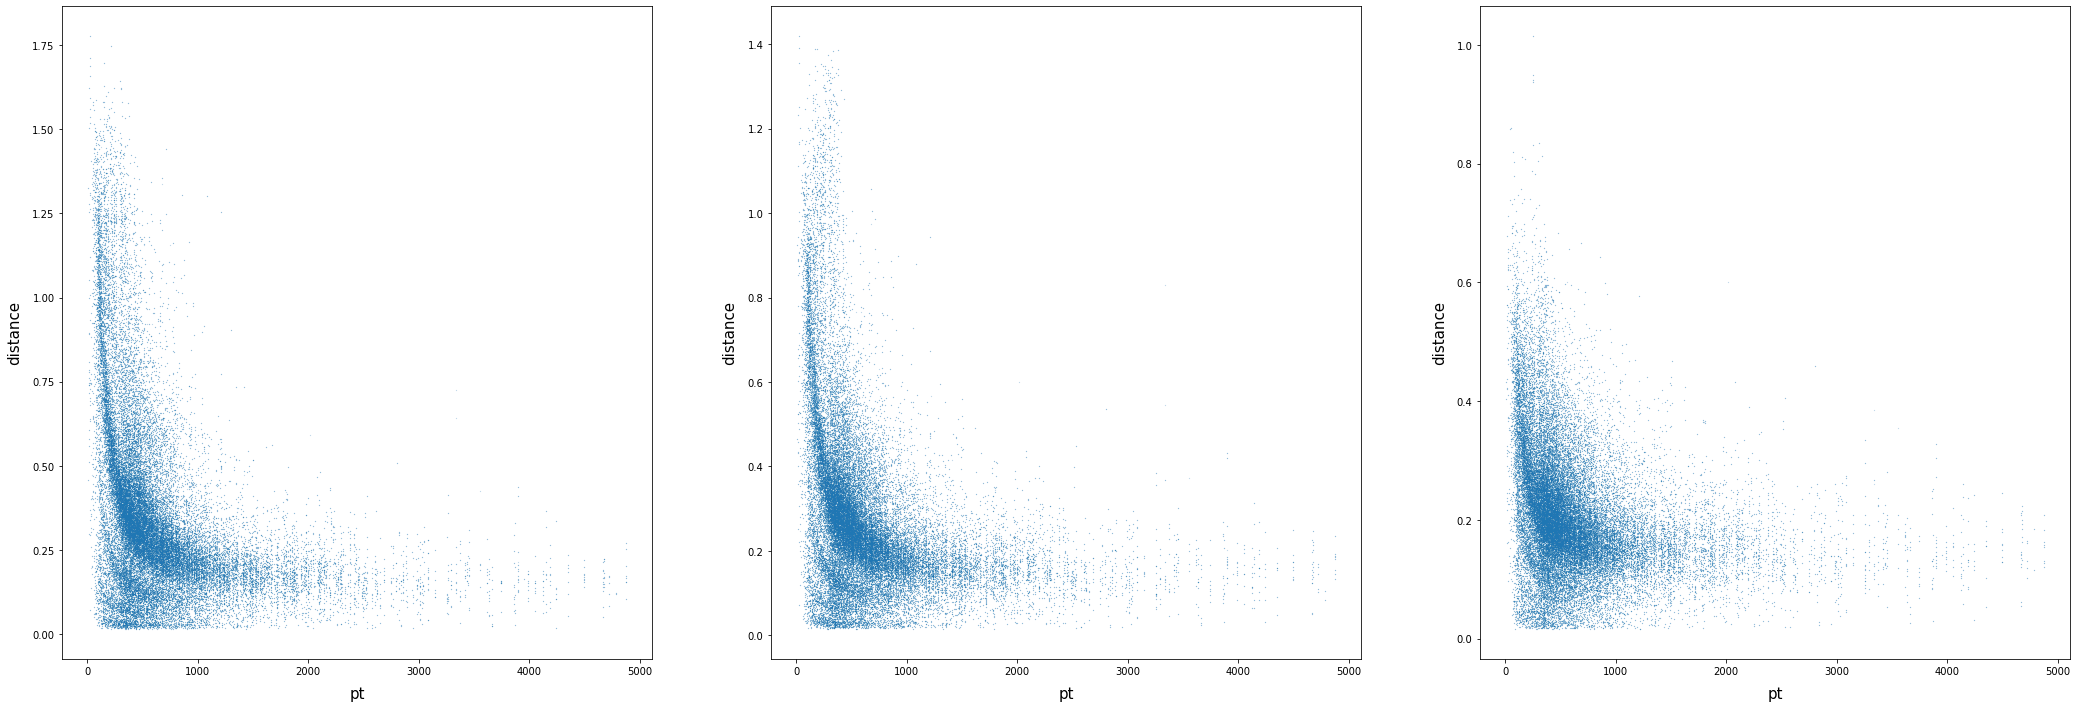

In [27]:
f = plt.figure(figsize = (12,12))    
f, axes = plt.subplots(nrows = 1, ncols = 3,figsize = (36,12))
axes[0].scatter(edge_pt_1[edge_pt_1<5000].detach().cpu().numpy(), truth_distance_1[edge_pt_1<5000].detach().cpu().numpy(), s=0.01)
axes[1].scatter(edge_pt_2[edge_pt_2<5000].detach().cpu().numpy(), truth_distance_2[edge_pt_2<5000].detach().cpu().numpy(), s=0.01)
axes[2].scatter(edge_pt_3[edge_pt_3<5000].detach().cpu().numpy(), truth_distance_3[edge_pt_3<5000].detach().cpu().numpy(), s=0.01)
axes[0].set_xlabel("pt", fontsize=15, labelpad = 10)
axes[0].set_ylabel("distance", fontsize=15, labelpad = 10)
axes[1].set_xlabel("pt", fontsize=15, labelpad = 10)
axes[1].set_ylabel("distance", fontsize=15, labelpad = 10)
axes[2].set_xlabel("pt", fontsize=15, labelpad = 10)
axes[2].set_ylabel("distance", fontsize=15, labelpad = 10)
plt.show()

In [52]:
pt_range = np.arange(50)*100
ratio = []
for i in range(len(pt_range)):
    mask = (edge_pt > pt_range[i]) & (edge_pt < pt_range[i]+100)
    ratio.append((((truth_distance[mask] < 0.4).sum()+1e-12)/(truth_distance[mask].shape[0]+1e-12)).item())

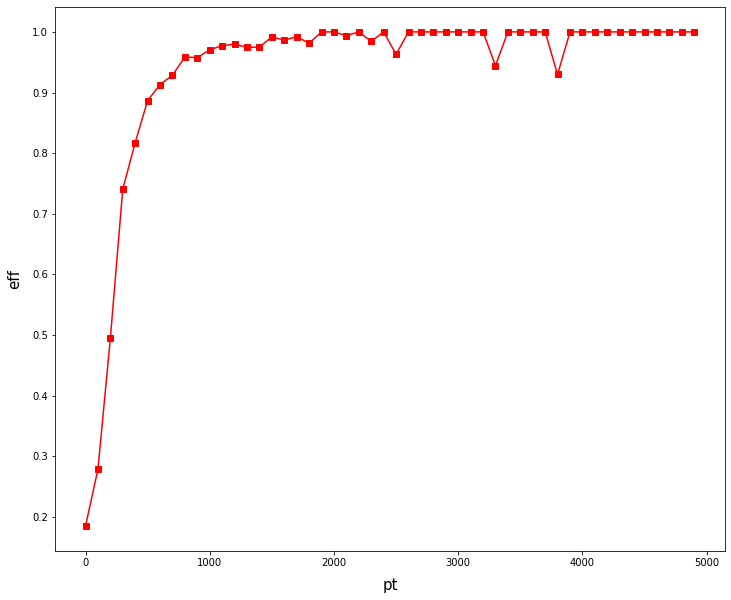

In [53]:
plt.figure(figsize=(12,10))
plt.plot(pt_range,ratio,'s-',color = 'r', label="TSMC")
plt.xlabel("pt", fontsize=15, labelpad = 10)
plt.ylabel("eff", fontsize=15, labelpad = 10)
plt.show()

# Reselect Data

In [22]:
class EmbeddingSelecting:
    def __init__(self, input_dir, output_dir, radius_cut, overwrite=False):
        
        self.output_dir = output_dir
        self.input_dir = input_dir
        self.overwrite = overwrite
        self.radius_cut = radius_cut

    def select(self):
        print("Selecting data...")
        
        all_events = os.listdir(self.input_dir)
        all_events = sorted([os.path.join(self.input_dir, event) for event in all_events])
        
        total_length = len(all_events)
        batch_incr = 0
        
        for event in all_events:
                percent = (batch_incr / total_length) * 100
                sys.stdout.flush()
                sys.stdout.write(f"{percent:.01f}% select complete\r")
                
                try:
                    batch = torch.load(event, map_location=torch.device("cuda"))
                except:
                    batch_incr += 1
                    continue
                batch.idxs[batch.dists > self.radius_cut**2] = -1
                
                delattr(batch, "dists")
                delattr(batch, "edge_index")
                
                self.save_downstream(batch)

                batch_incr += 1


    def save_downstream(self, batch):

        with open(
            os.path.join(self.output_dir, batch.event_file[-5:]), "wb"
        ) as pickle_file:
            torch.save(batch, pickle_file)

In [23]:
selector = EmbeddingSelecting("/global/cfs/cdirs/m3443/usr/ryanliu/ITk_embedding/ITk_processed/ITk_barrel_full/test/",
                              "/global/cfs/cdirs/m3443/usr/ryanliu/ITk_embedding/ITk_processed/ITk_barrel_full/eff98cut",
                              0.4008)

In [24]:
selector.select()

Selecting data...
